# Import Modules

In [1]:
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics import F1Score
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters Config

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=5,
        input_size_left_context=64,
        input_size_oov_context=20,
        input_size_right_context=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        output_size=3611,
        shuffle=True,
        lr=0.001,
        batch_first=True,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=20,
        patience=20,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device
        
hyperparams = Hyperparams()

# Prepare Feature Dataset

In [3]:
def convert_doc_to_idxs(docs, dict_vocabs):
    doc_to_idx = []
    
    for doc in docs:
        doc_to_idx.append([dict_vocabs[token] for token in doc])
        
    return np.array(doc_to_idx)

# Left context
left_context = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_with_pad.pkl", "rb")
left_context = pickle.load(left_context)
left_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_left_context.pkl", "rb")
left_context_to_idx = pickle.load(left_context_to_idx)
doc_left_context_to_idx = convert_doc_to_idxs(left_context, left_context_to_idx)

# OOV context
oov_context = open(f"../../datasets/features/{hyperparams.context_size}_context/oov_context_with_pad.pkl", "rb")
oov_context = pickle.load(oov_context)
oov_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_oov_context.pkl", "rb")
oov_context_to_idx = pickle.load(oov_context_to_idx)
doc_oov_context_to_idx = convert_doc_to_idxs(oov_context, oov_context_to_idx)

# Right context
right_context = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_with_pad.pkl", "rb")
right_context = pickle.load(right_context)
right_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_right_context.pkl", "rb")
right_context_to_idx = pickle.load(right_context_to_idx)
doc_right_context_to_idx = convert_doc_to_idxs(right_context, right_context_to_idx)

# Actual labels
labels_context = open(f"../../datasets/features/{hyperparams.context_size}_context/lables.pkl", "rb")
labels_context = pickle.load(labels_context)
labels_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/lable_vocabs.pkl", "rb")
labels_to_idx = pickle.load(labels_to_idx)
doc_labels_to_idx = convert_doc_to_idxs(labels_context, labels_to_idx).flatten()

print(f"Left context shape: {doc_left_context_to_idx.shape}")
print(f"OOV context shape: {doc_oov_context_to_idx.shape}")
print(f"Right context shape: {doc_right_context_to_idx.shape}")
print(f"Actual lable shape: {doc_labels_to_idx.shape}")

Left context shape: (16562, 5)
OOV context shape: (16562, 28)
Right context shape: (16562, 5)
Actual lable shape: (16562,)


In [4]:
# Convert to Tensor
left_contexts = torch.LongTensor(doc_left_context_to_idx)
oov_contexts = torch.LongTensor(doc_oov_context_to_idx)
right_contexts = torch.LongTensor(doc_right_context_to_idx)
actual_labels = torch.LongTensor(doc_labels_to_idx)
dataset = TensorDataset(left_contexts, oov_contexts, right_contexts, actual_labels)

# Char and Word Embedding

In [5]:
# Word Embedding
word_embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
word_embeddings.apply_expansion(DigitExpander)
word_embeddings.apply_expansion(CaseExpander)

left_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_vocabs.pkl", "rb")
left_vocabs = pickle.load(left_vocabs)

right_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_vocabs.pkl", "rb")
right_vocabs = pickle.load(right_vocabs)

left_word_embedding_dict = {left_context_to_idx[vocab] : word_embeddings[vocab] for vocab in left_vocabs}
right_word_embedding_dict = {right_context_to_idx[vocab] : word_embeddings[vocab] for vocab in right_vocabs}

# Char Embedding
char_embedding_dict = open("../../word_embeddings/chars_embedding/char_embeddings.pkl", "rb")
char_embedding_dict = pickle.load(char_embedding_dict)

# Context embedding
left_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(left_word_embedding_dict.values()))), padding_idx=left_vocabs.index("<PAD>"), freeze=True)
oov_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(char_embedding_dict.values()))), padding_idx=list(char_embedding_dict.keys()).index("PAD"), freeze=True)
right_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(right_word_embedding_dict.values()))), padding_idx=right_vocabs.index("<PAD>"), freeze=True)

# Dataloader

In [6]:
dataloader = DataLoader(dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

# Model

In [7]:
class Comick(nn.Module):
    def __init__(
        self,
        input_size_left_context=hyperparams.input_size_left_context,
        input_size_oov_context=hyperparams.input_size_oov_context,
        input_size_right_context=hyperparams.input_size_right_context,
        hidden_size=hyperparams.hidden_size,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(Comick, self).__init__()
        
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        
        self.bilstm_left_context_feature = nn.LSTM(
            input_size = self.input_size_left_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_oov_context_feature = nn.LSTM(
            input_size = self.input_size_oov_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_right_context_feature = nn.LSTM(
            input_size = self.input_size_right_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2 * self.hidden_size, 64),
            nn.Tanh()
        )
        
        self.oov_embedding = nn.Linear(in_features=3 * 64, out_features=64)
        
        self.embedding = np.empty((output_size, 64), dtype=np.float32)
        
        self.prob = nn.Sequential(
            nn.Linear(64, self.output_size),
            nn.LogSoftmax(dim=1)
        )
                
        if init_wb_with_kaiming_normal:
            self.init_wb()
            
    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))

    def forward(
        self,
        input_left_context,
        input_oov_context,
        input_right_context,
        idxs_target,
        hidden_left_context=None,
        hidden_oov_context=None,
        hidden_right_context=None,
    ):
        # BiLSTM left, oov, and right context
        output_left_context, (hidden_left_context, memory_left_context) = self.bilstm_left_context_feature(input_left_context, hidden_left_context)
        output_oov_context, (hidden_oov_context, memory_oov_context) = self.bilstm_oov_context_feature(input_oov_context, hidden_oov_context)
        output_right_context, (hidden_right_context, memory_right_context) = self.bilstm_right_context_feature(input_right_context, hidden_right_context)
                
        # Concate hidden (forward and backward hidden BiLSTM)
        hidden_left_bidirectional = torch.cat((hidden_left_context[0], hidden_left_context[-1]), dim=1)
        hidden_oov_bidirectional = torch.cat((hidden_oov_context[0], hidden_oov_context[-1]), dim=1)
        hidden_right_bidirectional = torch.cat((hidden_right_context[0], hidden_right_context[-1]), dim=1)
        
        # Fully connected
        output_left_fc = self.fc(hidden_left_bidirectional)
        output_oov_fc = self.fc(hidden_oov_bidirectional)
        output_right_fc = self.fc(hidden_right_bidirectional)
        
        # Concate output left, oov, and right context feature
        output = torch.cat((output_left_fc, output_oov_fc, output_right_fc), dim=1)
        
        # OOV embedding
        output = self.oov_embedding(output)
                
        # save OOV embedding
        self.embedding[idxs_target.tolist()] = output.cpu().detach().numpy()
        
        # Projection OOV embedding
        prob = self.prob(output)
        
        return prob

# Model, Optimizer, Criterion, Metric, and Learning Rate Scheduler

In [8]:
model = Comick().to(hyperparams.device)
model.prob[0].requires_grad_ = False # disable gradient for projection layer
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.NLLLoss(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
metric = F1Score(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5)
model

Comick(
  (bilstm_left_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (bilstm_oov_context_feature): LSTM(20, 128, batch_first=True, bidirectional=True)
  (bilstm_right_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (oov_embedding): Linear(in_features=192, out_features=64, bias=True)
  (prob): Sequential(
    (0): Linear(in_features=64, out_features=3611, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [9]:
print(f"{sum([param.numel() for param in model.parameters() if param.requires_grad_]):,}")

814,427


In [10]:
model.embedding

array([[ 4.7608371e+08,  4.5868703e-41,  4.7608371e+08, ...,
         3.4133611e-09, -1.2997603e-01,  4.5867301e-41],
       [-3.6591005e-01,  4.5867301e-41, -2.6801453e+14, ...,
         4.5867301e-41,  2.8742887e-02,  1.4299208e-19],
       [-1.2999606e-01,  4.5867301e-41, -3.6592436e-01, ...,
         4.5867301e-41, -3.6593390e-01,  4.5867301e-41],
       ...,
       [-7.3025417e-01,  4.5867301e-41,  5.9235689e-41, ...,
         4.5867301e-41,  5.9249702e-41,  0.0000000e+00],
       [-4.2789793e-01,  4.5867301e-41, -7.3029613e-01, ...,
         4.5867301e-41, -7.3033428e-01,  4.5867301e-41],
       [ 5.9265116e-41,  0.0000000e+00, -4.2790842e-01, ...,
         0.0000000e+00, -4.2791796e-01,  4.5867301e-41]], dtype=float32)

# Training Step

In [11]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None, path_name=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (input_left_context, input_oov_context, input_right_context, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        prob = model(
            left_context_embedding(input_left_context).to(hyperparams.device),
            oov_context_embedding(input_oov_context).to(hyperparams.device),
            right_context_embedding(input_right_context).to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
                
        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
        metric_score = metric.compute()
        
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if batch % 50 == 0 or batch == len(dataloader):
            batch_name = "Batch-" + str(batch)
            print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
            with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
                f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")

        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

# Looping Step

EPOCH-1


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=4.9493 | F1Score=0.2725
Batch-100: NLLLoss=4.4446 | F1Score=0.2909
Batch-150: NLLLoss=4.9178 | F1Score=0.3206
Batch-200: NLLLoss=4.3581 | F1Score=0.3442
Batch-250: NLLLoss=3.9365 | F1Score=0.3630
Batch-300: NLLLoss=4.1281 | F1Score=0.3838
Batch-350: NLLLoss=3.9852 | F1Score=0.3994
Batch-400: NLLLoss=2.1460 | F1Score=0.4112
Batch-450: NLLLoss=3.7887 | F1Score=0.4250
Batch-500: NLLLoss=3.2104 | F1Score=0.4371
Batch-518: NLLLoss=3.8726 | F1Score=0.4414

Mean NLLLoss: 4.5008 | Mean F1Score: 0.3544

EPOCH-2


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=2.7677 | F1Score=0.5969
Batch-100: NLLLoss=3.0023 | F1Score=0.6037
Batch-150: NLLLoss=3.8823 | F1Score=0.6037
Batch-200: NLLLoss=2.7733 | F1Score=0.6089
Batch-250: NLLLoss=3.0390 | F1Score=0.6152
Batch-300: NLLLoss=1.9653 | F1Score=0.6186
Batch-350: NLLLoss=3.0125 | F1Score=0.6238
Batch-400: NLLLoss=2.0441 | F1Score=0.6297
Batch-450: NLLLoss=3.0570 | F1Score=0.6354
Batch-500: NLLLoss=2.3068 | F1Score=0.6415
Batch-518: NLLLoss=2.3837 | F1Score=0.6414

Yeah 🎉😄! Model improved.
Mean NLLLoss: 2.6688 | Mean F1Score: 0.6145

EPOCH-3


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=1.7750 | F1Score=0.7381
Batch-100: NLLLoss=1.0679 | F1Score=0.7341
Batch-150: NLLLoss=1.9932 | F1Score=0.7347
Batch-200: NLLLoss=2.0454 | F1Score=0.7363
Batch-250: NLLLoss=1.4217 | F1Score=0.7386
Batch-300: NLLLoss=1.9684 | F1Score=0.7377
Batch-350: NLLLoss=2.8830 | F1Score=0.7389
Batch-400: NLLLoss=1.2515 | F1Score=0.7418
Batch-450: NLLLoss=2.8111 | F1Score=0.7435
Batch-500: NLLLoss=2.8509 | F1Score=0.7457
Batch-518: NLLLoss=1.6859 | F1Score=0.7464

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.7654 | Mean F1Score: 0.7380

EPOCH-4


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.6201 | F1Score=0.8044
Batch-100: NLLLoss=0.6631 | F1Score=0.8095
Batch-150: NLLLoss=0.9093 | F1Score=0.8140
Batch-200: NLLLoss=0.9734 | F1Score=0.8158
Batch-250: NLLLoss=1.0257 | F1Score=0.8155
Batch-300: NLLLoss=1.1232 | F1Score=0.8146
Batch-350: NLLLoss=1.3017 | F1Score=0.8169
Batch-400: NLLLoss=0.8664 | F1Score=0.8169
Batch-450: NLLLoss=1.4780 | F1Score=0.8189
Batch-500: NLLLoss=1.3077 | F1Score=0.8206
Batch-518: NLLLoss=0.2977 | F1Score=0.8215

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.1192 | Mean F1Score: 0.8143

EPOCH-5


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.4676 | F1Score=0.8847
Batch-100: NLLLoss=0.3820 | F1Score=0.8895
Batch-150: NLLLoss=0.4746 | F1Score=0.8949
Batch-200: NLLLoss=0.3253 | F1Score=0.8963
Batch-250: NLLLoss=0.8914 | F1Score=0.8951
Batch-300: NLLLoss=0.8962 | F1Score=0.8940
Batch-350: NLLLoss=0.3195 | F1Score=0.8914
Batch-400: NLLLoss=1.4678 | F1Score=0.8899
Batch-450: NLLLoss=0.7976 | F1Score=0.8868
Batch-500: NLLLoss=0.5529 | F1Score=0.8849
Batch-518: NLLLoss=0.8409 | F1Score=0.8839

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.6330 | Mean F1Score: 0.8903

EPOCH-6


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.2095 | F1Score=0.9675
Batch-100: NLLLoss=0.2743 | F1Score=0.9663
Batch-150: NLLLoss=0.1327 | F1Score=0.9671
Batch-200: NLLLoss=0.5201 | F1Score=0.9667
Batch-250: NLLLoss=0.2392 | F1Score=0.9649
Batch-300: NLLLoss=0.1620 | F1Score=0.9621
Batch-350: NLLLoss=0.2730 | F1Score=0.9606
Batch-400: NLLLoss=0.2015 | F1Score=0.9588
Batch-450: NLLLoss=0.3088 | F1Score=0.9575
Batch-500: NLLLoss=0.2682 | F1Score=0.9557
Batch-518: NLLLoss=0.1918 | F1Score=0.9547

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.2686 | Mean F1Score: 0.9625

EPOCH-7


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.1297 | F1Score=0.9931
Batch-100: NLLLoss=0.0966 | F1Score=0.9919
Batch-150: NLLLoss=0.0661 | F1Score=0.9935
Batch-200: NLLLoss=0.0640 | F1Score=0.9945
Batch-250: NLLLoss=0.0156 | F1Score=0.9948
Batch-300: NLLLoss=0.0165 | F1Score=0.9947
Batch-350: NLLLoss=0.0809 | F1Score=0.9946
Batch-400: NLLLoss=0.0748 | F1Score=0.9940
Batch-450: NLLLoss=0.0163 | F1Score=0.9940
Batch-500: NLLLoss=0.2423 | F1Score=0.9937
Batch-518: NLLLoss=0.0333 | F1Score=0.9936

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0730 | Mean F1Score: 0.9936

EPOCH-8


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0328 | F1Score=0.9991
Batch-100: NLLLoss=0.0146 | F1Score=0.9986
Batch-150: NLLLoss=0.0128 | F1Score=0.9991
Batch-200: NLLLoss=0.0708 | F1Score=0.9991
Batch-250: NLLLoss=0.0111 | F1Score=0.9991
Batch-300: NLLLoss=0.0141 | F1Score=0.9993
Batch-350: NLLLoss=0.0164 | F1Score=0.9989
Batch-400: NLLLoss=0.0237 | F1Score=0.9989
Batch-450: NLLLoss=0.0157 | F1Score=0.9987
Batch-500: NLLLoss=0.0064 | F1Score=0.9989
Batch-518: NLLLoss=0.0128 | F1Score=0.9989

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0209 | Mean F1Score: 0.9990

EPOCH-9


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0067 | F1Score=0.9994
Batch-100: NLLLoss=0.0057 | F1Score=0.9995
Batch-150: NLLLoss=0.0053 | F1Score=0.9989
Batch-200: NLLLoss=0.0052 | F1Score=0.9989
Batch-250: NLLLoss=0.0169 | F1Score=0.9990
Batch-300: NLLLoss=0.0049 | F1Score=0.9992
Batch-350: NLLLoss=0.0060 | F1Score=0.9991
Batch-400: NLLLoss=0.0115 | F1Score=0.9991
Batch-450: NLLLoss=0.0066 | F1Score=0.9991
Batch-500: NLLLoss=0.0061 | F1Score=0.9990
Batch-518: NLLLoss=0.0055 | F1Score=0.9990

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0118 | Mean F1Score: 0.9991

EPOCH-10


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0612 | F1Score=0.9994
Batch-100: NLLLoss=0.0052 | F1Score=0.9992
Batch-150: NLLLoss=0.0052 | F1Score=0.9995
Batch-200: NLLLoss=0.0045 | F1Score=0.9995
Batch-250: NLLLoss=0.0058 | F1Score=0.9994
Batch-300: NLLLoss=0.0070 | F1Score=0.9995
Batch-350: NLLLoss=0.0053 | F1Score=0.9994
Batch-400: NLLLoss=0.0070 | F1Score=0.9994
Batch-450: NLLLoss=0.0148 | F1Score=0.9992
Batch-500: NLLLoss=0.2227 | F1Score=0.9981
Batch-518: NLLLoss=0.2375 | F1Score=0.9969

Huft 😥! Model not improved.
Mean NLLLoss: 0.0195 | Mean F1Score: 0.9993
Patience = 1/20❗

EPOCH-11


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.1672 | F1Score=0.9619
Batch-100: NLLLoss=0.1252 | F1Score=0.9578
Batch-150: NLLLoss=0.1235 | F1Score=0.9588
Batch-200: NLLLoss=0.1739 | F1Score=0.9584
Batch-250: NLLLoss=0.0952 | F1Score=0.9619
Batch-300: NLLLoss=0.0881 | F1Score=0.9645
Batch-350: NLLLoss=0.1025 | F1Score=0.9676
Batch-400: NLLLoss=0.0980 | F1Score=0.9695
Batch-450: NLLLoss=0.1482 | F1Score=0.9711
Batch-500: NLLLoss=0.0262 | F1Score=0.9726
Batch-518: NLLLoss=0.1147 | F1Score=0.9728

Huft 😥! Model not improved.
Mean NLLLoss: 0.1273 | Mean F1Score: 0.9643
Patience = 2/20❗

EPOCH-12


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0079 | F1Score=0.9937
Batch-100: NLLLoss=0.0333 | F1Score=0.9953
Batch-150: NLLLoss=0.0106 | F1Score=0.9966
Batch-200: NLLLoss=0.0032 | F1Score=0.9973
Batch-250: NLLLoss=0.0196 | F1Score=0.9976
Batch-300: NLLLoss=0.0184 | F1Score=0.9980
Batch-350: NLLLoss=0.0064 | F1Score=0.9979
Batch-400: NLLLoss=0.0038 | F1Score=0.9980
Batch-450: NLLLoss=0.0074 | F1Score=0.9981
Batch-500: NLLLoss=0.0089 | F1Score=0.9983
Batch-518: NLLLoss=0.0170 | F1Score=0.9984

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0138 | Mean F1Score: 0.9969

EPOCH-13


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0020 | F1Score=0.9981
Batch-100: NLLLoss=0.0015 | F1Score=0.9983
Batch-150: NLLLoss=0.0043 | F1Score=0.9983
Batch-200: NLLLoss=0.0016 | F1Score=0.9987
Batch-250: NLLLoss=0.0030 | F1Score=0.9990
Batch-300: NLLLoss=0.0012 | F1Score=0.9991
Batch-350: NLLLoss=0.0022 | F1Score=0.9992
Batch-400: NLLLoss=0.0009 | F1Score=0.9993
Batch-450: NLLLoss=0.0016 | F1Score=0.9993
Batch-500: NLLLoss=0.0029 | F1Score=0.9994
Batch-518: NLLLoss=0.0012 | F1Score=0.9994

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0055 | Mean F1Score: 0.9988

EPOCH-14


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0018 | F1Score=1.0000
Batch-100: NLLLoss=0.0019 | F1Score=1.0000
Batch-150: NLLLoss=0.0016 | F1Score=1.0000
Batch-200: NLLLoss=0.0007 | F1Score=1.0000
Batch-250: NLLLoss=0.0013 | F1Score=1.0000
Batch-300: NLLLoss=0.0011 | F1Score=1.0000
Batch-350: NLLLoss=0.0013 | F1Score=0.9999
Batch-400: NLLLoss=0.0020 | F1Score=0.9997
Batch-450: NLLLoss=0.0009 | F1Score=0.9997
Batch-500: NLLLoss=0.0020 | F1Score=0.9996
Batch-518: NLLLoss=0.0009 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0028 | Mean F1Score: 0.9999

EPOCH-15


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0009 | F1Score=0.9994
Batch-100: NLLLoss=0.0007 | F1Score=0.9997
Batch-150: NLLLoss=0.0008 | F1Score=0.9998
Batch-200: NLLLoss=0.0013 | F1Score=0.9997
Batch-250: NLLLoss=0.0008 | F1Score=0.9996
Batch-300: NLLLoss=0.0010 | F1Score=0.9996
Batch-350: NLLLoss=0.0009 | F1Score=0.9996
Batch-400: NLLLoss=0.0009 | F1Score=0.9997
Batch-450: NLLLoss=0.0025 | F1Score=0.9997
Batch-500: NLLLoss=0.0005 | F1Score=0.9997
Batch-518: NLLLoss=0.0015 | F1Score=0.9997

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0022 | Mean F1Score: 0.9996

EPOCH-16


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0006 | F1Score=0.9997
Batch-100: NLLLoss=0.0008 | F1Score=0.9998
Batch-150: NLLLoss=0.0008 | F1Score=0.9999
Batch-200: NLLLoss=0.0007 | F1Score=0.9997
Batch-250: NLLLoss=0.0006 | F1Score=0.9997
Batch-300: NLLLoss=0.0477 | F1Score=0.9996
Batch-350: NLLLoss=0.0009 | F1Score=0.9996
Batch-400: NLLLoss=0.0010 | F1Score=0.9997
Batch-450: NLLLoss=0.0005 | F1Score=0.9997
Batch-500: NLLLoss=0.0017 | F1Score=0.9996
Batch-518: NLLLoss=0.0022 | F1Score=0.9996

Huft 😥! Model not improved.
Mean NLLLoss: 0.0022 | Mean F1Score: 0.9997
Patience = 3/20❗

EPOCH-17


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0008 | F1Score=0.9991
Batch-100: NLLLoss=0.0013 | F1Score=0.9992
Batch-150: NLLLoss=0.0022 | F1Score=0.9989
Batch-200: NLLLoss=0.0110 | F1Score=0.9977
Batch-250: NLLLoss=0.0918 | F1Score=0.9903
Batch-300: NLLLoss=0.1247 | F1Score=0.9811
Batch-350: NLLLoss=0.1165 | F1Score=0.9770
Batch-400: NLLLoss=0.1711 | F1Score=0.9736
Batch-450: NLLLoss=0.0884 | F1Score=0.9733
Batch-500: NLLLoss=0.2026 | F1Score=0.9724
Batch-518: NLLLoss=0.0737 | F1Score=0.9719

Huft 😥! Model not improved.
Mean NLLLoss: 0.1136 | Mean F1Score: 0.9870
Patience = 4/20❗

EPOCH-18


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0478 | F1Score=0.9784
Batch-100: NLLLoss=0.1191 | F1Score=0.9811
Batch-150: NLLLoss=0.0116 | F1Score=0.9841
Batch-200: NLLLoss=0.0095 | F1Score=0.9865
Batch-250: NLLLoss=0.0135 | F1Score=0.9879
Batch-300: NLLLoss=0.0856 | F1Score=0.9891
Batch-350: NLLLoss=0.0090 | F1Score=0.9893
Batch-400: NLLLoss=0.0620 | F1Score=0.9900
Batch-450: NLLLoss=0.0302 | F1Score=0.9902
Batch-500: NLLLoss=0.0260 | F1Score=0.9906
Batch-518: NLLLoss=0.0066 | F1Score=0.9909

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0411 | Mean F1Score: 0.9864

EPOCH-19


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0049 | F1Score=0.9984
Batch-100: NLLLoss=0.0122 | F1Score=0.9987
Batch-150: NLLLoss=0.0021 | F1Score=0.9990
Batch-200: NLLLoss=0.0007 | F1Score=0.9989
Batch-250: NLLLoss=0.0015 | F1Score=0.9990
Batch-300: NLLLoss=0.0012 | F1Score=0.9989
Batch-350: NLLLoss=0.0034 | F1Score=0.9987
Batch-400: NLLLoss=0.0016 | F1Score=0.9987
Batch-450: NLLLoss=0.0020 | F1Score=0.9989
Batch-500: NLLLoss=0.0029 | F1Score=0.9989
Batch-518: NLLLoss=0.0009 | F1Score=0.9990

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0063 | Mean F1Score: 0.9987

EPOCH-20


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0008 | F1Score=1.0000
Batch-100: NLLLoss=0.0007 | F1Score=1.0000
Batch-150: NLLLoss=0.0008 | F1Score=1.0000
Batch-200: NLLLoss=0.0007 | F1Score=1.0000
Batch-250: NLLLoss=0.0017 | F1Score=0.9999
Batch-300: NLLLoss=0.0007 | F1Score=0.9999
Batch-350: NLLLoss=0.0008 | F1Score=1.0000
Batch-400: NLLLoss=0.0014 | F1Score=1.0000
Batch-450: NLLLoss=0.0005 | F1Score=1.0000
Batch-500: NLLLoss=0.0005 | F1Score=0.9999
Batch-518: NLLLoss=0.0003 | F1Score=0.9999

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0008 | Mean F1Score: 1.0000

TRAINING SUMMARY
Best NLLLoss      : 0.0008
Best F1Score      : 1.0000
Training duration : 15.600 minutes.
Training date     : 2022-10-11 10:46:07.827845+08:00


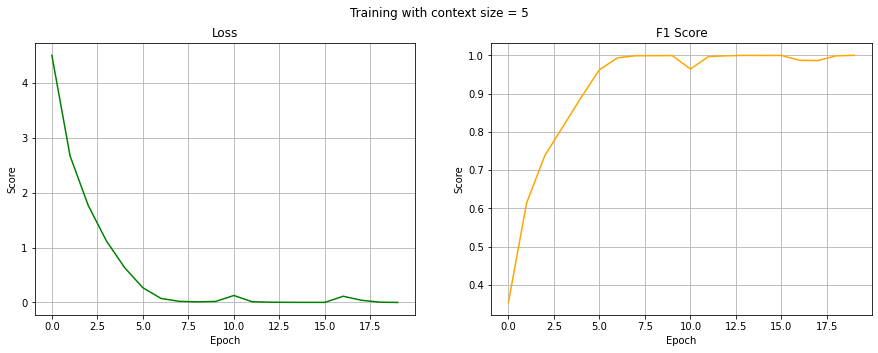

In [12]:
def looping_step(dataloader, model, optimizer, criterion, metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_losses = []
    epoch_metric_scores = []
    patience_counter = 0
    
    now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
    path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
    os.makedirs(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}")
    
    # Hyperparameters
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 50}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 50}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
        
        batch_losses, batch_metric_scores = training_step(dataloader, model, optimizer, criterion, metric, path_name=path_name)
        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))

        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))
        epoch_losses.append(epoch_loss.item())

        epoch_metric_score = torch.mean(torch.FloatTensor(batch_metric_scores))
        epoch_metric_scores.append(epoch_metric_score.item())
        
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_losses[-1] < epoch_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")                    
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_metric_scores[-1] > epoch_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 50, end="\n\n")
            f.write(f"{'=' * 50}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        metric.reset()
    
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_losses, "green")
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_metric_scores, "orange")
    ax_metric_score.grid()

    plt.savefig(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    criterion_name = "Best " + str(criterion).split('(')[0]
    metric_name = "Best " + str(metric).split('(')[0]
    
    print(f"{criterion_name.ljust(18)}: {best_loss:.4f}")
    print(f"{metric_name.ljust(18)}: {best_metric:.4f}")
    print(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.")
    print(f"{'Training date'.ljust(18)}: {now}")
    
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 50}\n")
        f.write(f"{criterion_name.ljust(18)}: {best_loss:.4f}\n")
        f.write(f"{metric_name.ljust(18)}: {best_metric:.4f}\n")
        f.write(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.\n")
        f.write(f"{'Training date'.ljust(18)}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    filename_model_params = f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/model_params.pth"
    filename_oov_embedding_dict = open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/oov_embedding_dict.pkl", "ab")
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_losses) + 1)),
            "loss": epoch_losses
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_losses.csv", index=False)
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_metric_scores) + 1)),
            "f1_score": epoch_metric_scores
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_metric_scores.csv", index=False)
    
    torch.save(best_state_dict, filename_model_params)
    pickle.dump({token : embedding for token, embedding in zip(list(labels_to_idx.keys()), model.embedding)}, filename_oov_embedding_dict)
    
    return epoch_losses, epoch_metric_scores

epoch_losses, epoch_metric_scores = looping_step(dataloader, model, optimizer, criterion, metric)

# END

In [13]:
model.embedding

array([[-0.08177552,  3.4917564 , -1.7330387 , ..., -3.160685  ,
        -3.6529143 ,  2.8096874 ],
       [-4.5110197 , -1.1607728 ,  1.121459  , ..., -2.2128086 ,
         0.7655026 ,  2.0275364 ],
       [-3.888116  ,  1.160452  , -0.78306866, ..., -2.1279495 ,
         8.180297  , -0.5095711 ],
       ...,
       [ 0.7003872 ,  1.7030112 ,  3.224115  , ...,  3.4815285 ,
         4.63665   ,  4.4156938 ],
       [-0.6242177 ,  1.1067756 , -5.786417  , ..., -1.3055314 ,
         1.8261601 , -0.7588409 ],
       [-6.3236055 ,  0.8073404 , -2.6239612 , ..., -4.7953086 ,
         1.0511272 ,  0.83219975]], dtype=float32)

In [14]:
model.state_dict()

OrderedDict([('bilstm_left_context_feature.weight_ih_l0',
              tensor([[-0.1398, -0.4922,  0.1892,  ..., -0.1143,  0.1498, -0.0958],
                      [ 0.3886,  0.2465,  0.1183,  ..., -0.2244,  0.3998, -0.3014],
                      [ 0.7082, -0.1068, -0.3910,  ..., -0.5828,  0.0831,  0.0723],
                      ...,
                      [-0.6066,  0.4591, -0.2254,  ...,  0.5708, -0.2926,  0.5051],
                      [ 0.1456, -0.0609,  0.1332,  ...,  0.5298,  0.2369,  0.5270],
                      [-0.1805,  0.0399,  0.2400,  ...,  0.3176,  0.0037, -0.1619]])),
             ('bilstm_left_context_feature.weight_hh_l0',
              tensor([[-0.1387,  0.1005, -0.1141,  ..., -0.0073,  0.1475,  0.0202],
                      [-0.1085, -0.1175, -0.0514,  ..., -0.2259, -0.4115,  0.3099],
                      [ 0.2935,  0.1532, -0.0320,  ..., -0.0685,  0.2383, -0.2636],
                      ...,
                      [ 0.0293, -0.0186,  0.0813,  ..., -0.2635,  0.131